First we write some starter code to generate data

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
font = {'size': 18}
matplotlib.rc('font', **font)

%matplotlib inline

In [0]:
# Define the true function f
def f(x):
    return 100 * (x - 0.5) ** 3 - 10 * x + 2 * x + 2 * 6.25

In [0]:
# Generate a list of x's so we can properly draw the model
xs = np.linspace(0, 1, 1000).reshape((1000, 1))

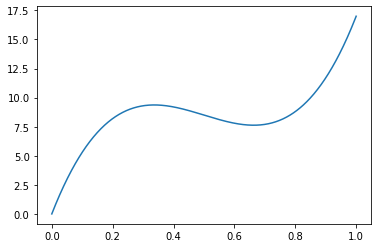

In [0]:
plt.plot(xs, f(xs))

In [0]:
# Generate 20 random data points
X = np.random.uniform(0 , 1, 20).reshape((20, 1))
X

array([[0.51978166],
       [0.32738947],
       [0.6713648 ],
       [0.05112713],
       [0.91152348],
       [0.8426922 ],
       [0.65737208],
       [0.72436712],
       [0.05150502],
       [0.42035122],
       [0.25383305],
       [0.57056263],
       [0.42305305],
       [0.94234912],
       [0.38386539],
       [0.94270754],
       [0.34579529],
       [0.94671439],
       [0.26795725],
       [0.90025616]])

In [0]:
# Generate 20 noisy targets for training data
y = f(X) + np.random.normal(0, 1, (20, 1))

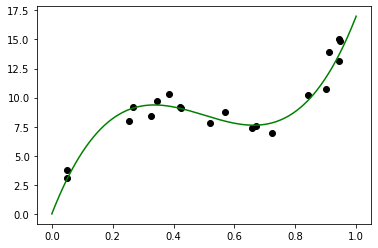

In [0]:
# Plot them together
plt.plot(xs, f(xs), color='green')
plt.scatter(X, y, color='black')

# Demo 1: Lasso Regression
This demo shows how the penalty for $\lambda$ affects the resulting function

In [0]:
# Simple code to train a Lasso model
from sklearn.linear_model import Lasso
model = Lasso(alpha=1.5)

In [0]:
from sklearn.preprocessing import PolynomialFeatures

# Define the function for plotting
def poly_model_lasso(lam, degree, X, y, xs, ):
    # Generate polynomial features of degree p
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    xs_poly = poly.transform(xs)

    # Train the model and make predictions along all xs
    model = Lasso(alpha=lam)
    model.fit(X_poly, y)
    predictions = model.predict(xs_poly)

    # Plot the prediction results
    plt.scatter(X, y, label='Data', c='black')
    plt.plot(xs, predictions, label='Predicted f')

    # Customize plot for readability
    plt.title(f'Lambda {lam:0.2e}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")  # Legend outside plot
    plt.xlim(0, 1)
    plt.ylim(0, y.max() + 1)

    plt.show()

In [0]:
# Define interaction code
from ipywidgets import fixed, interactive, IntSlider, FloatLogSlider, widget, widgets

interactive_plot = interactive(poly_model_lasso, 
                               lam=FloatLogSlider(min=-3, max=3, value=-3),
                               degree=IntSlider(min=0, max=20, value=1),
                               X=fixed(X),
                               y=fixed(y),
                               xs=fixed(xs))

output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatLogSlider(value=0.001, description='lam', max=3.0, min=-3.0), IntSlider(value=1, de…

# Demo 2: Visualizing Lasso Regression
First, some set up work to setup the initial state to make computations faster

In [0]:
import math

from ipywidgets import interactive, FloatLogSlider, FloatSlider, widget, widgets
from IPython.display import display

from matplotlib import ticker

# Make a datset that has features of all 1s for the intercept
X_mod = np.ones((X.shape[0], 2))
X_mod[:, 1] = X[:, 0]


def compute_lasso_path(X, y, lambdas):
    """
    Computes the LASSO Regression coefficient path for the given list of lambdas
    
    Trains a Lasso model for each value of lambda and returns the coefficients
    as a (2, len(lambdas)) array storing the coefficients as columns.
    """
    coefs = np.zeros((2, len(lambdas)))
    for i, lam in enumerate(lambdas):
        model = Lasso(alpha=lam, fit_intercept=False)
        model.fit(X, y)
        coefs[:, i] = model.coef_
    return coefs
    
    
def rss(X, y, w0s, w1s):
    """
    Compute the value of the RSS metric for each combo of w0 and w1
    
    Returns a numpy array of RSS values of size ((w0s.size, w1s.size))
    """
    rss_values = np.zeros(shape=(w0s.size, w1s.size))

    # For every setting of w0 and w1
    for i, w0 in enumerate(w0s):
        for j, w1 in enumerate(w1s):
            w = np.array([w0, w1]).reshape((2,1))
            # This computes RSS(w)
            rss_values[j, i] = np.sum((y - X @ w) ** 2) 
    return rss_values / (2 * len(X))

# Set up common state
lambda_params = (-5, 2)
lambdas = np.logspace(lambda_params[0], lambda_params[1], 50)
coefs = compute_lasso_path(X_mod, y, lambdas)
w0s = np.linspace(-15, 15, 200)
w1s = np.linspace(-15, 15, 200)
# Clever: We only have to compute RSS once since it only dpeends on data and possible w0s and w1s
rss_values = rss(X_mod, y, w0s=w0s, w1s=w1s)

In [0]:
def plot_contour(axis, w0s, w1s, values):
    """
    Plots a contour plot on the given axis using w0s as the x-axis,
    w1s as the y-axis, and values as the z-axis.
    """
    # First, plot the color gradient
    axis.contourf(w0s, w1s, values, levels=100, alpha=.5)
    
    # Then plot the labelled contours
    cs = axis.contour(w0s, w1s, values, levels=10, colors='black')
    axis.clabel(cs, inline=1, fontsize=8)
    
    # Then draw the x and y axes
    axis.axhline(0, color='black', alpha=.5, dashes=[2, 4], linewidth=1)
    axis.axvline(0, color='black', alpha=0.5, dashes=[2, 4], linewidth=1)
    axis.set_xlim(w0s.min(), w0s.max())
    axis.set_ylim(w1s.min(), w1s.max())

    
# Setup the objects that hold widget state
w0_widget  = FloatSlider(min=math.floor(w0s.min()), max=math.ceil(w0s.max()), continuous_update=False)
w1_widget  = FloatSlider(min=math.floor(w1s.min()), max=math.ceil(w1s.max()), continuous_update=False)
lam_widget = FloatLogSlider(min=lambda_params[0], max=lambda_params[1], value=lambda_params[0], continuous_update=False)

def do_ols(event):
    """
    When clicked, will fit a LinearRegression model to the data and change the values for the widgets
    """
    model = LinearRegression(fit_intercept=False)
    model.fit(X_mod, y)
    w0_widget.value = model.coef_[0, 0]
    w1_widget.value = model.coef_[0, 1]
    


def do_lasso(event):
    """
    When clicked, will fit a Lasso model to the data and change the values for the widgets
    """
    model = Lasso(alpha=lam_widget.value, fit_intercept=False)
    model.fit(X_mod, y)
    print(lam_widget.value, model)
    print(model.coef_)
    w0_widget.value = model.coef_[0]
    w1_widget.value = model.coef_[1]
    
# Create the buttons
button_ols = widgets.Button(
    description='Find Ordinary Least Squares Solution',
    layout={'width': '300px'}
)
button_ols.on_click(do_ols) 
button_lasso = widgets.Button(
    description='Find LASSO Regression Solution',
    layout={'width': '300px'}
)
button_lasso.on_click(do_lasso)


def plot(w0, w1, lam, show_path):
    """
    Plots the graph showing the quality metric at the different w0 and w1 pairs using lambda strength
    lam for Lasso regression. If show_path is True, shows coefficient paths.
    """
    if show_path:
        fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))
        ax4.axis('off')
        ax6.axis('off')
    else:
        fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(30, 7))
        

    xs = np.linspace(0, 1, 100)
    
    # Plot the data on ax1
    ax1.scatter(X, y, c='black', label='Data')
    ax1.plot(xs, w0 + w1 * xs, label=f'y = {w0:.2f} + {w1:.2f}x')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.05, y.max() + 1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Data + Prediction')
    ax1.legend()
    
    # Plot 2 shows RSS alone
    plot_contour(ax2, w0s, w1s, rss_values)
    if show_path:
        ax2.plot(coefs[0, :], coefs[1, :], c='w')
    ax2.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax2.set_title('Ordinary Least Squares QM')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    
    # Plot 3 shows RSS + L1 Norm
    lasso_penalties = np.abs(w0s.reshape((w0s.shape[0], 1)))  + np.abs(w1s)
    plot_contour(ax3, w0s, w1s, rss_values + lam * lasso_penalties)
    if show_path:
        ax3.plot(coefs[0, :], coefs[1, :], c='w')
    ax3.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax3.set_xlabel('w0')
    ax3.set_ylabel('w1')
    ax3.set_title(f'Lasso Regression QM: Lambda={lam:.2e}')

    
    # Show the standard coefficient path chart
    if show_path:
        ax5.plot(lambdas, coefs[0, :], label='w0')
        ax5.plot(lambdas, coefs[1, :], label='w1')
        
        ax5.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax5.set_xlabel('lambda')
        ax5.set_ylabel('magnitude')
        ax5.set_title('Coefficient Path')
        
    plt.show()

interactive_plot = interactive(plot, w0=w0_widget, w1=w1_widget, lam=lam_widget, show_path=False)
output = interactive_plot.children[-1]
output.layout.height = '800px'

Ordinary Least Squares
$$\hat{w}_{LS} = \min_w RSS(w)$$

Lasso Regression

$$\hat{w}_{lasso} = \min_w RSS(w) + \lambda ||w||_1$$

In [0]:
display(widgets.HBox([button_ols, button_lasso]))
interactive_plot

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='w0', max=15.0, min=-15.0), …

# Demo 6b: Visualizing LASSO Regression - Don't Penalize Intercept
Here is the exact repeat of all the code from before, but that doesn't penalize $w_0$

In [0]:
from sklearn.linear_model import Lasso

In [0]:
import math

from ipywidgets import interactive, FloatLogSlider, FloatSlider, widget, widgets
from IPython.display import display

from matplotlib import ticker

def compute_lasso_path2(X, y, lambdas):
    coefs = np.zeros((2, len(lambdas)))
    for i, lam in enumerate(lambdas):
        model = Lasso(alpha=lam, fit_intercept=True)
        model.fit(X, y)
        coefs[0, i] = model.intercept_
        coefs[1, i] = model.coef_[0]
    return coefs

    
def rss2(X, y, w0s, w1s):
    rss_values = np.zeros(shape=(w0s.size, w1s.size))

    # For every setting of w0 and w1
    for i, w0 in enumerate(w0s):
        for j, w1 in enumerate(w1s):
            # This computes RSS(w)
            rss_values[j, i] = np.sum((y - (w0 + X * w1)) ** 2) / (2 * len(X))
    return rss_values

lambda_params2 = (-5, 2)
lambdas2 = np.logspace(lambda_params2[0], lambda_params2[1], 50)
coefs2 = compute_lasso_path2(X, y, lambdas2)
w0s2 = np.linspace(-15, 15, 200)
w1s2 = np.linspace(-15, 15, 200)
rss_values2 = rss2(X, y, w0s=w0s2, w1s=w1s2)

In [0]:
def plot_contour(axis, w0s, w1s, values):
    # First, plot the color gradient
    axis.contourf(w0s, w1s, values, levels=100, alpha=.5)
    
    # Then plot the labelled contours
    cs = axis.contour(w0s, w1s, values, levels=10, colors='black')
    axis.clabel(cs, inline=1, fontsize=8)
    
    # Then draw the x and y axes
    axis.axhline(0, color='black', alpha=.5, dashes=[2, 4], linewidth=1)
    axis.axvline(0, color='black', alpha=0.5, dashes=[2, 4], linewidth=1)
    axis.set_xlim(w0s.min(), w0s.max())
    axis.set_ylim(w1s.min(), w1s.max())

    
# Setup the objects that hold widget state
w0_widget2  = FloatSlider(min=math.floor(w0s2.min()), max=math.ceil(w0s2.max()), continuous_update=False)
w1_widget2  = FloatSlider(min=math.floor(w1s2.min()), max=math.ceil(w1s2.max()), continuous_update=False)
lam_widget2 = FloatLogSlider(min=lambda_params2[0], max=lambda_params2[1], value=lambda_params2[0], continuous_update=False)


# Define the buttons that will find the OLS or lasso solutions
def do_ols2(event):
    model = LinearRegression()
    model.fit(X, y)
    w0_widget2.value = model.intercept_
    w1_widget2.value = model.coef_[0, 0]
    
    
def do_lasso2(event):
    model = Lasso(alpha=lam_widget2.value)
    model.fit(X, y)
    w0_widget2.value = model.intercept_
    w1_widget2.value = model.coef_[0]
    
# Creat the buttons 
button_ols2 = widgets.Button(
    description='Find Ordinary Least Squares Solution',
    layout={'width': '300px'}
)
button_ols2.on_click(do_ols2)   
button_lasso2 = widgets.Button(
    description='Find LASSO Regression Solution',
    layout={'width': '300px'}
)
button_lasso2.on_click(do_lasso2)


def plot(w0, w1, lam, show_path):
    if show_path:
        fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))
        ax4.axis('off')
        ax6.axis('off')
    else:
        fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(30, 7))
        

    xs = np.linspace(0, 1, 100)
    
    # Plot the data on ax1
    ax1.scatter(X, y, c='black', label='Data')
    ax1.plot(xs, w0 + w1 * xs, label=f'y = {w0:.2f} + {w1:.2f}x')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.05, y.max() + 1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Data + Prediction')
    ax1.legend()
    
    # Plot 2 shows RSS alone
    plot_contour(ax2, w0s2, w1s2, rss_values2)
    if show_path:
        ax2.plot(coefs2[0, :], coefs2[1, :], c='w')
    ax2.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax2.set_title('Ordinary Least Squares QM')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    
    # Plot 3 shows RSS + L1 Norm
    lasso_penalties = np.abs(w1s2.reshape((w1s2.shape[0], 1))) + np.zeros((w1s2.shape[0]))
    plot_contour(ax3, w0s2, w1s2, rss_values2 + lam * lasso_penalties)
    if show_path:
        ax3.plot(coefs2[0, :], coefs2[1, :], c='w')
    ax3.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax3.set_xlabel('w0')
    ax3.set_ylabel('w1')
    ax3.set_title(f'LASSO Regression QM: Lambda={lam:.2e}')

    
    # Show the s2tandard coefficient path chart
    if show_path:
        ax5.plot(lambdas, coefs2[0, :], label='w0')
        ax5.plot(lambdas, coefs2[1, :], label='w1')
        
        ax5.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax5.set_xlabel('lambda')
        ax5.set_ylabel('magnitude')
        ax5.set_title('Coefficient Path')
        
    plt.show()

interactive_plot2 = interactive(plot, w0=w0_widget2, w1=w1_widget2, lam=lam_widget2, show_path=False)
output = interactive_plot2.children[-1]
output.layout.height = '800px'

In [0]:
display(widgets.HBox([button_ols2, button_lasso2]))
interactive_plot2

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='w0', max=15.0, min=-15.0), …